### Proposal Work

In [1]:
# Add libraries
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(dplyr)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Read data from .csv file
survey <- read.csv('survey lung cancer.csv')
head(survey)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC.DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL.CONSUMING,COUGHING,SHORTNESS.OF.BREATH,SWALLOWING.DIFFICULTY,CHEST.PAIN,LUNG_CANCER
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
2,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
3,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
4,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
5,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
6,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES


In [3]:
# Change most of the variables to boolean variables instead of integer or string variables
survey_2 <- survey %>%
    summarize(gender = GENDER,
              age = AGE,
              smoking = SMOKING - 1 == 1,
              yellow_fingers = YELLOW_FINGERS - 1 == 1,
              anxiety = ANXIETY - 1 == 1,
              chronic_disease = CHRONIC.DISEASE - 1 == 1,
              fatigue = FATIGUE - 1 == 1,
              allergy = ALLERGY - 1 == 1,
              wheezing = WHEEZING - 1 == 1,
              alcohol_consuming = ALCOHOL.CONSUMING - 1 == 1,
              coughing = COUGHING - 1 == 1,
              shortness_of_breath = SHORTNESS.OF.BREATH - 1 == 1,
              swallowing_difficulty = SWALLOWING.DIFFICULTY - 1 == 1,
              chest_pain = CHEST.PAIN - 1 == 1,
              lung_cancer = LUNG_CANCER == "YES"
             )
head(survey_2)

,gender,age,smoking,yellow_fingers,anxiety,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
,<chr>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,M,69,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
2,M,74,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
3,F,59,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE
4,M,63,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE
5,F,63,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
6,F,75,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE


In [4]:
# Clean and wrangle data; we are only interested in people who have lung cancer and whether or not they smoked and/or consumed alcohol
survey_clean_wrangled <- survey_2 %>%
    filter(lung_cancer == TRUE) %>%
    select(gender, smoking, alcohol_consuming) %>%
    mutate(none = !smoking & !alcohol_consuming, both = smoking & alcohol_consuming)

head(survey_clean_wrangled)

,gender,smoking,alcohol_consuming,none,both
,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
1,M,FALSE,TRUE,FALSE,FALSE
2,M,TRUE,FALSE,FALSE,FALSE
3,F,FALSE,FALSE,TRUE,FALSE
4,M,TRUE,TRUE,FALSE,TRUE
5,F,TRUE,FALSE,FALSE,FALSE
6,M,TRUE,TRUE,FALSE,TRUE


In [5]:
# Summarize proportions of smokers, drinkers, people who did both, and people who did neither
survey_summary_clean_wrangled <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(none_prop = mean(smoking != TRUE & alcohol_consuming != TRUE),
              smoking_prop = mean(smoking == TRUE & alcohol_consuming != TRUE),
              alcohol_consuming_prop = mean(alcohol_consuming == TRUE & smoking != TRUE),
              both_prop = mean(smoking == TRUE & alcohol_consuming == TRUE))

survey_summary_clean_wrangled

gender,none_prop,smoking_prop,alcohol_consuming_prop,both_prop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.22400000,0.4000000,0.2160000,0.1600000
M,0.08275862,0.1034483,0.3310345,0.4827586


In [6]:
# Determine proportion, standard error, and confidence intervals
none_prop_CI <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(none_prop = mean(smoking != TRUE & alcohol_consuming != TRUE),
              se = sqrt(none_prop * (1 - none_prop) / n()),
              lower_ci = none_prop - (qnorm(0.975) * se),
              upper_ci = none_prop + (qnorm(0.975) * se))

smoking_prop_CI <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(smoking_prop = mean(smoking == TRUE & alcohol_consuming != TRUE),
              se = sqrt(smoking_prop * (1 - smoking_prop) / n()),
              lower_ci = smoking_prop - (qnorm(0.975) * se),
              upper_ci = smoking_prop + (qnorm(0.975) * se))

alcohol_consuming_prop_CI <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(alcohol_consuming_prop = mean(smoking != TRUE & alcohol_consuming == TRUE),
              se = sqrt(alcohol_consuming_prop* (1 - alcohol_consuming_prop) / n()),
              lower_ci = alcohol_consuming_prop - (qnorm(0.975) * se),
              upper_ci = alcohol_consuming_prop + (qnorm(0.975) * se))

both_prop_CI <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(both_prop = mean(smoking == TRUE & alcohol_consuming == TRUE),
              se = sqrt(both_prop * (1 - both_prop) / n()),
              lower_ci = both_prop - (qnorm(0.975) * se),
              upper_ci = both_prop + (qnorm(0.975) * se))

smoking_prop_CI
alcohol_consuming_prop_CI

gender,smoking_prop,se,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.4000000,0.04381780,0.31411868,0.4858813
M,0.1034483,0.02529096,0.05387891,0.1530176


gender,alcohol_consuming_prop,se,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.2160000,0.03680696,0.1438597,0.2881403
M,0.3310345,0.03907999,0.2544391,0.4076299


In [7]:
# Create bootstrap distributions using the clean and wrangled data, then calculate the proportion differences between genders
set.seed(1)
bootstrap_survey_smoking <- survey_clean_wrangled %>%
    mutate(only_smoking = !alcohol_consuming & smoking) %>%
    specify(formula = only_smoking ~ gender, success = "TRUE") %>%
    hypothesize(null = "independence") %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in props", order = c("F", "M"))

set.seed(1)
bootstrap_survey_alcohol_consuming <- survey_clean_wrangled %>%
    mutate(only_alcohol_consuming = alcohol_consuming & !smoking) %>%
    specify(formula = only_alcohol_consuming ~ gender, success = "TRUE") %>%
    hypothesize(null = "independence") %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in props", order = c("F", "M"))

set.seed(1)
bootstrap_survey_both <- survey_clean_wrangled %>%
    specify(formula = both ~ gender, success = "TRUE") %>%
    hypothesize(null = "independence") %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in props", order = c("F", "M"))

set.seed(1)
bootstrap_survey_none <- survey_clean_wrangled %>%
    specify(formula = none ~ gender, success = "TRUE") %>%
    hypothesize(null = "independence") %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in props", order = c("F", "M"))

**Smoking Only Differences in Proportions**

In [8]:
head(bootstrap_survey_smoking)

replicate,stat
<int>,<dbl>
1,0.2355167
2,0.2928037
3,0.3438735
4,0.3073549
5,0.2296296
6,0.2258224


**Drinking Only Differences in Proportions**

In [9]:
head(bootstrap_survey_alcohol_consuming)

replicate,stat
<int>,<dbl>
1,-0.07062163
2,-0.11531690
3,-0.14393939
4,-0.20850202
5,-0.08888889
6,-0.07688506


**Smoking and Drinking Differences in Proportions**

In [10]:
#head(bootstrap_survey_both)

**Non-Smoking and Non-Drinking Differences in Proportions**

In [11]:
#head(bootstrap_survey_none)

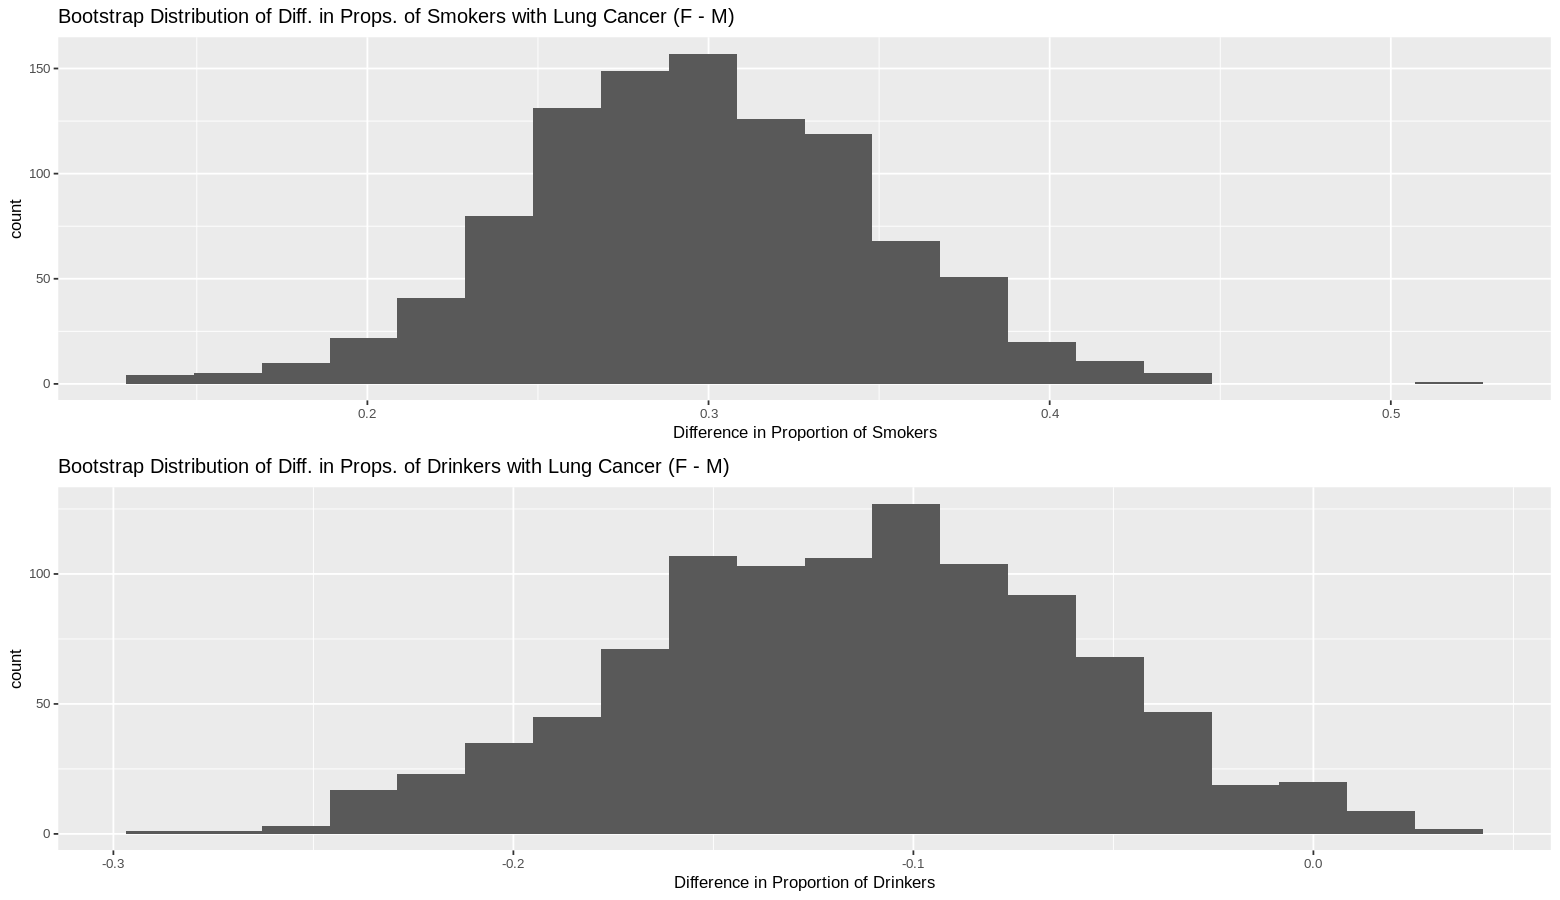

In [12]:
# Increase size of plots
options(repr.plot.width = 13, repr.plot.height = 7.5)

# Plot the bootstrap distribution of the smokers only group
bootstrap_survey_smoking_plot <- bootstrap_survey_smoking %>%
    ggplot(aes(x = stat)) +
        geom_histogram(bins = 20) +
        labs(x = "Difference in Proportion of Smokers") +
        ggtitle("Bootstrap Distribution of Diff. in Props. of Smokers with Lung Cancer (F - M)") +
        theme(text = element_text(size = 10))

# Plot the bootstrap distribution of the drinkers only group
bootstrap_survey_alcohol_consuming_plot <- bootstrap_survey_alcohol_consuming %>%
    ggplot(aes(x = stat)) +
        geom_histogram(bins = 20) +
        labs(x = "Difference in Proportion of Drinkers") +
        ggtitle("Bootstrap Distribution of Diff. in Props. of Drinkers with Lung Cancer (F - M)") +
        theme(text = element_text(size = 10))

# Plot the bootstrap distribution of the smokers and drinkers group
bootstrap_survey_both_plot <- bootstrap_survey_both %>%
    ggplot(aes(x = stat)) +
        geom_histogram(bins = 20) +
        labs(x = "Difference in Proportion of Smokers and Drinkers") +
        ggtitle("Bootstrap Distribution of Diff. in Props. of Smokers and Drinkers with Lung Cancer (F - M)") +
        theme(text = element_text(size = 10))

# Plot the bootstrap distribution of the non-smokers and non-drinkers group
bootstrap_survey_none_plot <- bootstrap_survey_none %>%
    ggplot(aes(x = stat)) +
        geom_histogram(bins = 20) +
        labs(x = "Difference in Proportion of Non-Smokers and Non-Drinkers") +
        ggtitle("Bootstrap Distribution of Diff. in Props. of Non-Smokers and Non-Drinkers with Lung Cancer (F - M)") +
        theme(text = element_text(size = 10))

grid.arrange(bootstrap_survey_smoking_plot,
             bootstrap_survey_alcohol_consuming_plot,
             ncol = 1)

### New Work

In [13]:
# Set type I error to 5%, can be changed
alpha = 0.05

Can the Central Limit Theorem be applied?

The sample observations do not depend on each other, so they were drawn in an independent fashion.

In [14]:
nrow(survey_clean_wrangled)

[1] 270

This sample size is nowhere near 10% of the total number of lung cancer patients in the world.

In [15]:
# Summarize number of smokers, drinkers, people who did both, and people who did neither
survey_num_observations_clean_wrangled <- survey_clean_wrangled %>%
    group_by(gender) %>%
    summarize(none_num = sum(smoking != TRUE & alcohol_consuming != TRUE),
              smoking_num = sum(smoking == TRUE & alcohol_consuming != TRUE),
              alcohol_consuming_num = sum(alcohol_consuming == TRUE & smoking != TRUE),
              both_num = sum(smoking == TRUE & alcohol_consuming == TRUE))

survey_num_observations_clean_wrangled

gender,none_num,smoking_num,alcohol_consuming_num,both_num
<chr>,<int>,<int>,<int>,<int>
F,28,50,27,20
M,12,15,48,70


In [16]:
survey_summary_clean_wrangled

gender,none_prop,smoking_prop,alcohol_consuming_prop,both_prop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.22400000,0.4000000,0.2160000,0.1600000
M,0.08275862,0.1034483,0.3310345,0.4827586


In [17]:
survey_num_observations_clean_wrangled %>%
    mutate(none_n_p = none_num * survey_summary_clean_wrangled$none_prop,
           smoking_n_p = smoking_num * survey_summary_clean_wrangled$smoking_prop,
           alcohol_consuming_n_p = alcohol_consuming_num * survey_summary_clean_wrangled$alcohol_consuming_prop,
           both_n_p = both_num * survey_summary_clean_wrangled$both_prop,
           none_n_1_minus_p = none_num * (1 - survey_summary_clean_wrangled$none_prop),
           smoking_n_1_minus_p = smoking_num * (1 - survey_summary_clean_wrangled$smoking_prop),
           alcohol_consuming_n_1_minus_p = alcohol_consuming_num * (1 - survey_summary_clean_wrangled$alcohol_consuming_prop),
           both_n_1_minus_p = both_num * (1 - survey_summary_clean_wrangled$both_prop)) %>%
    select(-none_num, -smoking_num, -alcohol_consuming_num, -both_num)

gender,none_n_p,smoking_n_p,alcohol_consuming_n_p,both_n_p,none_n_1_minus_p,smoking_n_1_minus_p,alcohol_consuming_n_1_minus_p,both_n_1_minus_p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,6.2720000,20.000000,5.83200,3.2000,21.7280,30.00000,21.16800,16.8000
M,0.9931034,1.551724,15.88966,33.7931,11.0069,13.44828,32.11034,36.2069


Some of the numbers in the table above are less than 10. For those sections, the CLT will not be applicable to either the male or female block. Because of this, there is no guarantee that the differences in proportions between the blocks in the bootstrap distributions would follow a normal distribution.

Try adding normal or t-distributions onto the bootstrap distributions anyways.

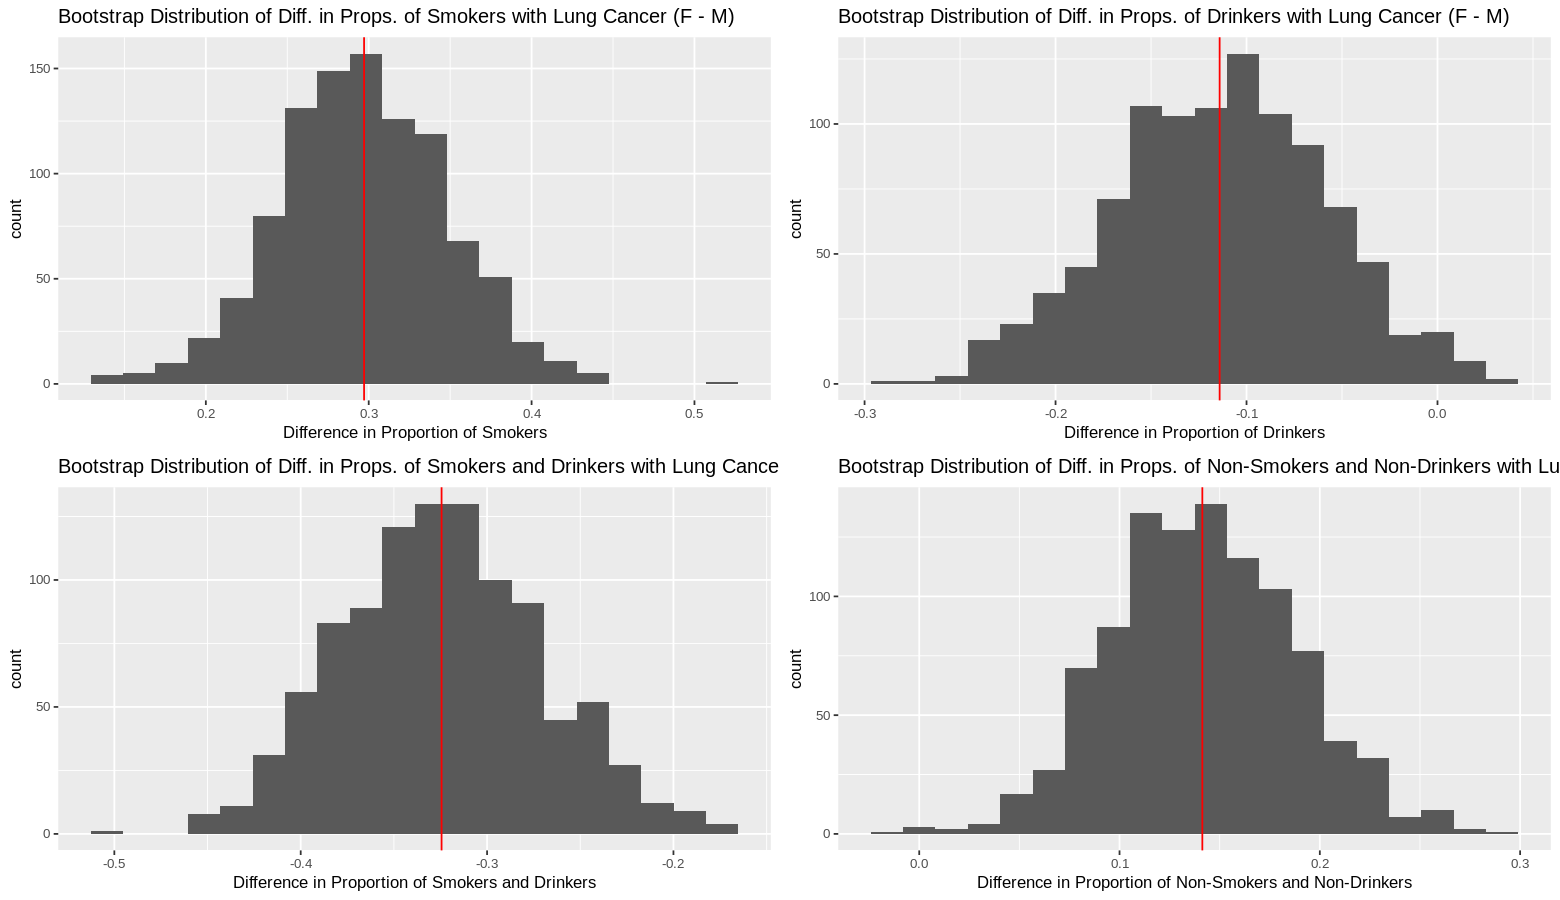

In [18]:
bootstrap_survey_smoking_plot_norm <- bootstrap_survey_smoking_plot +
    geom_vline(xintercept = mean(bootstrap_survey_smoking$stat), color = "red")
bootstrap_survey_alcohol_consuming_plot_norm <- bootstrap_survey_alcohol_consuming_plot +
    geom_vline(xintercept = mean(bootstrap_survey_alcohol_consuming$stat), color = "red")
bootstrap_survey_both_plot_norm <- bootstrap_survey_both_plot +
    geom_vline(xintercept = mean(bootstrap_survey_both$stat), color = "red")
bootstrap_survey_none_plot_norm <- bootstrap_survey_none_plot +
    geom_vline(xintercept = mean(bootstrap_survey_none$stat), color = "red")

grid.arrange(bootstrap_survey_smoking_plot_norm,
             bootstrap_survey_alcohol_consuming_plot_norm,
             bootstrap_survey_both_plot_norm,
             bootstrap_survey_none_plot_norm,
             ncol = 2)

2 sample z-test to test if smoke and alcohol affect lung cancer
- $H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$

To test $H_0$, we use the following test statistic:

$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$
where $\hat{p}_1$ and $\hat{p}_2$ are the sample proportions in samples 1 and 2, respectively; $n$ is the sample size; and $\hat{p}$ is the pooled proportion, given by: 

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$ from(worksheet 8)


In [19]:
#p1 = smoker with lung cancer, p2 = drinker with lung cancer
survey_summary_clean_wrangled
survey_num_observations_clean_wrangled

gender,none_prop,smoking_prop,alcohol_consuming_prop,both_prop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.22400000,0.4000000,0.2160000,0.1600000
M,0.08275862,0.1034483,0.3310345,0.4827586


gender,none_num,smoking_num,alcohol_consuming_num,both_num
<chr>,<int>,<int>,<int>,<int>
F,28,50,27,20
M,12,15,48,70


In [20]:
#calculate test statistic (female)
p1_female <- survey_summary_clean_wrangled$smoking_prop[1]
p2_female <- survey_summary_clean_wrangled$alcohol_consuming_prop[1]
n1_female <- survey_num_observations_clean_wrangled$smoking_num[1]
n2_female <- survey_num_observations_clean_wrangled$alcohol_consuming_num[1]

p_hat_female <- (n1_female * p1_female + n2_female * p2_female) / (n1_female + n2_female)
z_score_female <- (p1_female - p2_female) / sqrt(p_hat_female * (1 - p_hat_female) * (1 / n1_female + 1 / n2_female))
p_hat_female
z_score_female

[1] 0.3354805

[1] 1.631743

In [21]:
p_value_female <- pnorm(z_score_female, lower.tail = FALSE)
p_value_female
reject_null = p_value_female < alpha
reject_null

[1] 0.05136679

[1] FALSE

In [22]:
#calculate test statistic (male)
p1_male <- survey_summary_clean_wrangled$smoking_prop[2]
p2_male <- survey_summary_clean_wrangled$alcohol_consuming_prop[2]
n1_male <- survey_num_observations_clean_wrangled$smoking_num[2]
n2_male <- survey_num_observations_clean_wrangled$alcohol_consuming_num[2]

p_hat_male <- (n1_male * p1_male + n2_male * p2_male) / (n1_male + n2_male)
z_score_male <- (p1_male - p2_male) / sqrt(p_hat_male * (1 - p_hat_male) * (1 / n1_male + 1 / n2_male))
p_hat_male
z_score_male

[1] 0.2768473

[1] -1.719518

In [23]:
p_value_male <- pnorm(z_score_male, lower.tail = FALSE)
p_value_male
reject_null = p_value_male < alpha
reject_null

[1] 0.95724

[1] FALSE